In [1]:
import torch
import torch.nn.functional as F
import random

In [2]:
words = open('../names.txt').read().split()

In [3]:
stoi = {s: i+1 for i, s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {s: i for i, s in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:

def build_dataset(words: list[str]):
    X, Y = [], []
    context_size = 3
    for w in words:
        context = [0] * context_size
        for ch in w + ".":
            X.append(context)
            Y.append(stoi[ch])
            # output = [itos[i] for i in context]
            # print(f"{''.join(output)} ----> {ch}")
            context = context[1:] + [stoi[ch]]
    return torch.tensor(X), torch.tensor(Y)


n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))
random.shuffle(words)

X_train, Y_train = build_dataset(words=words[:n1])
X_dev, Y_dev = build_dataset(words=words[n1:n2])
X_test, Y_test = build_dataset(words=words[n2:])

X_train.shape, X_dev.shape, X_test.shape

(torch.Size([182447, 3]), torch.Size([22952, 3]), torch.Size([22747, 3]))

In [5]:
g = torch.Generator().manual_seed(42)

In [6]:
C = torch.rand((27, 10), generator=g)
emb = C[X_train]
emb.shape

torch.Size([182447, 3, 10])

In [ ]:
C = torch.rand((27, 10), generator=g)
W1 = torch.rand((30, 256), generator=g)
b1 = torch.rand(256, generator=g)
W2 = torch.rand((256, 27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in parameters)

11897

In [9]:
for p in parameters:
    p.requires_grad = True

In [10]:
def forward(inputs, column):
    emb = C[inputs]
    h = torch.tanh(emb.view(-1, column) @ W1+b1)
    logits = h @ W2 + b2
    return logits

In [11]:
n_iter = 10001
lre = torch.linspace(-3, 0, n_iter)
lrs = 10**lre
# lrs[9900:10000]

In [12]:
stepi, lossi, lossd = [], [], []

In [ ]:
# n_iter = 10000
lre = torch.linspace(-3, 0, n_iter)
lrs = 10**lre
for i in range(n_iter):

    # minibatch
    ix = torch.randint(0, X_train.shape[0], (62,))

    # emb = C[]
    inputs = X_train[ix]
    targets_training = Y_train[ix]
    logits_train = forward(inputs, column=30)
    loss_train = F.cross_entropy(logits_train, targets_training)

    logits_dev = forward(X_dev, column=30)
    loss_dev = F.cross_entropy(logits_dev, Y_dev)

    if i == 0 or i == n_iter or i % 1000 == 0:
        print(f"step {i}  train loss: {
              loss_train:.4f}  dev loss: {loss_dev:.4f} ")

    for p in parameters:
        p.grad = None
    loss_train.backward()

    # updating gradient
    # lr = lrs[i]
    lr = 0.1 if i < 1000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss_train.log10().item())
    lossd.append(loss_dev.log10().item())

step 0  train loss: 9.4429  dev loss: 8.9189 
step 10000  train loss: 3.0460  dev loss: 2.8353 


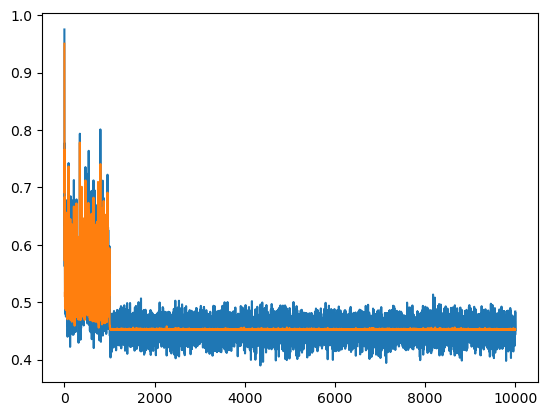

In [14]:
import matplotlib.pyplot as plt
plt.plot(stepi, lossi)
plt.plot(stepi, lossd)
plt.show()

In [15]:
# expl_count = 5
# for i in range(expl_count):
#     # context = [0] * 3